In [3]:
import os
from PIL import Image
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import models
from torchvision.datasets import Cityscapes
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# pyton 3.9.11 / cuda / windows
# pip install torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0 --index-url https://download.pytorch.org/whl/cu121 
# print("Cuda available: ", torch.cuda.is_available())
# print("Device name:", torch.cuda.get_device_name())

In [ ]:
# data_path = '/Users/severin/Documents/Projects/segmentation/cityscapes'
data_path = "Q:/Projects/u-net-segmentation-of-streets-and-cars/train/cityscapes"

In [6]:
def transform_image(img):
    return torch.from_numpy(np.array(img)).long()

In [7]:
# Define your data transformation (you might need to customize these)
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images
    transforms.ToTensor(),  # Convert to tensor
])

def transform_image(img):
    return torch.from_numpy(np.array(img)).long()

# Define your target transformation
target_transforms = transforms.Compose([
 transforms.Resize((256, 256)), # Resize target
 transforms.Lambda(lambda img: torch.Tensor(np.array(img))), 
])

# Create Cityscapes dataset instance
dataset = Cityscapes(root=data_path, split='train', mode='fine', 
                     target_type='semantic', transform=data_transforms, 
                     target_transform=target_transforms)

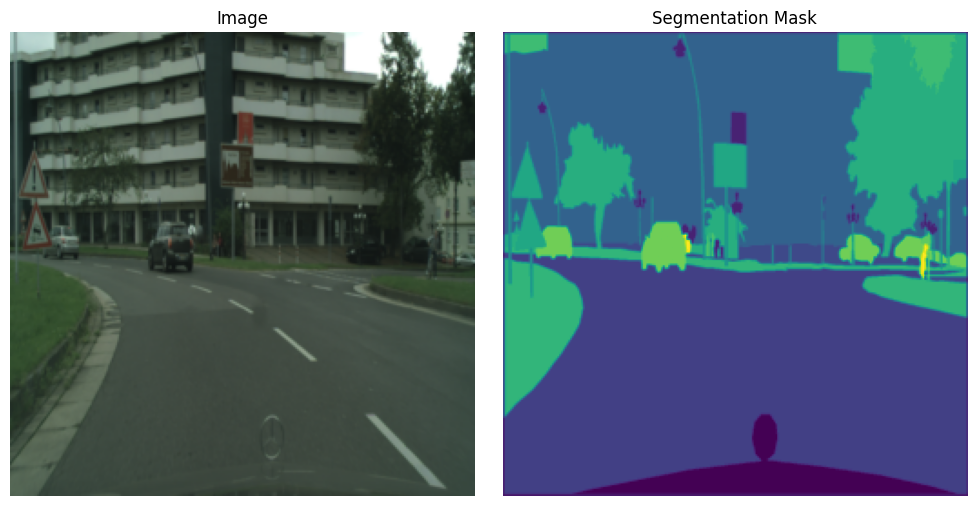

In [8]:
# Visualize the first image and its segmentation mask
img, smnt = dataset[0]

# Convert tensors to numpy arrays
img_np = img.permute(1, 2, 0).numpy()
smnt_np = np.array(smnt)

# Plotting
plt.figure(figsize=(10, 5))

# Display the image
plt.subplot(1, 2, 1)
plt.title('Image')
plt.imshow(img_np)
plt.axis('off')

# Display the segmentation mask
plt.subplot(1, 2, 2)
plt.title('Segmentation Mask')
plt.imshow(smnt_np)
plt.axis('off')

plt.tight_layout()
plt.show()

In [16]:
# Create DataLoader for easy iteration
batch_size = 32 
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
                  
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use GPU if available

# Load a pretrained model
model = models.segmentation.fcn_resnet101(pretrained=True) # Load a pretrained FCN-ResNet101 

# Replace the classifier part for your task
num_classes = len(Cityscapes.classes)
model.classifier[-1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1)) 

# Move the model to the GPU
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Number of epochs to train
num_epochs = 1 

# Start training loop
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch + 1, num_epochs))
    print('-' * 10)
    
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device).long()    # Convert the type of labels to Long
        
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs['out']
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        print('Loss: {}'.format(loss.item())) 
        
        del loss, outputs, labels  # Manually delete tensors to free memory
        
        
    print('Epoch completed.')

print('Training completed.')

torch.save(model.state_dict(), 'model_weights_v2.pth')

Epoch 1/1
----------
Loss: 3.5905110836029053
Loss: 3.584789514541626
Loss: 3.58168363571167
Loss: 3.567155122756958
Loss: 3.5455355644226074
Loss: 3.5346686840057373
Loss: 3.5099592208862305
Loss: 3.486829996109009
Loss: 3.4548749923706055
Loss: 3.437570333480835
Loss: 3.4086480140686035
Loss: 3.3829894065856934
Loss: 3.32942795753479
Loss: 3.3002076148986816
Loss: 3.2823586463928223
Loss: 3.249342918395996
Loss: 3.2119340896606445
Loss: 3.2019076347351074
Loss: 3.1658637523651123
Loss: 3.1339573860168457
Loss: 3.08263897895813
Loss: 3.038447141647339
Loss: 2.961108446121216
Loss: 2.934014320373535
Loss: 2.929910182952881
Loss: 2.8429181575775146
Loss: 2.819863796234131
Loss: 2.8179469108581543
Loss: 2.7697718143463135
Loss: 2.7260141372680664
Loss: 2.662287712097168
Loss: 2.662850856781006
Loss: 2.654987335205078
Loss: 2.5809333324432373
Loss: 2.5122084617614746
Loss: 2.529611587524414
Loss: 2.4696784019470215
Loss: 2.491802930831909
Loss: 2.3510262966156006
Loss: 2.3473901748657227


In [35]:
# Load the state dictionary
state_dict = torch.load('model_weights.pth')

# Remove keys related to auxiliary classifiers from the state dictionary
state_dict = {k: v for k, v in state_dict.items() if 'aux_classifier' not in k}

# Create your model and load the modified state dictionary
num_classes = len(Cityscapes.classes)
model = models.segmentation.fcn_resnet101(weights=False, num_classes=num_classes)
model.load_state_dict(state_dict, strict=False)  # Set strict=False to skip missing keys

# Load the input image
input_image = Image.open(f'{data_path}/leftImg8bit/train/zurich/zurich_000017_000019_leftImg8bit.png')

# Apply the necessary transformations
input_tensor = data_transforms(input_image).unsqueeze(0)

# Perform prediction
with torch.no_grad():
    outputs = model(input_tensor)['out']  # Correct 'inputs' to 'input_tensor'
    _, predicted = torch.max(outputs, 1)

# Convert the predicted image tensor to a numpy array
predicted_numpy = predicted.squeeze(0).cpu().numpy()

# Define label colors for 35 classes (replace this with your color mappings)
label_colors_35_classes = np.random.randint(0, 256, size=(35, 3), dtype=np.uint8)

# Convert the predicted segmentation mask to a colored mask
colored_mask = label_colors_35_classes[predicted_numpy]

# Plot the original input image and the colored mask
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(input_image)
axs[0].axis('off')
axs[0].set_title('Input Image')
axs[1].imshow(colored_mask)
axs[1].axis('off')
axs[1].set_title('Predicted Segmentation Mask')

plt.show()

<All keys matched successfully>